<h1>Agentic RAG</h1>

<h2>Setup</h2>

In [89]:
from dotenv import load_dotenv

load_dotenv()

True

In [90]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

llm = ChatOpenAI(model="gpt-4o", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [91]:
# Test
response = llm.invoke("Hi")
response

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-e0230ae5-05ce-45d3-83d7-96b3e615b024-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

<h2>Retriever</h2>

In [92]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls] #Load documents
docs_list = [item for sublist in docs for item in sublist] #Flatten the list

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

In [93]:
# Test
question = "agent memory"
documents = retriever.invoke(question) #the default number of retrieved documents (k) is 4, return a list of documents
type(documents)

list

In [94]:
type(documents[0])

langchain_core.documents.base.Document

In [95]:
documents[0].page_content

'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'

Then we create a retriever tool.

In [96]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_blog_posts",
    description="Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

<h2>Grader</h2>

In [97]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: int = Field(
        description="Documents are relevant to the question, 0 or 1"
    )

# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """
You are a grader assessing relevance of a retrieved document to a user question. 
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
Give a binary score 0 or 1 score to indicate whether the document is relevant to the question."""

human_msg = """
    Retrieved documents: 
    {documents} 
    
    User question: 
    {question}""" 

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", human_msg),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [98]:
grade_prompt.pretty_print() 

================================ System Message ================================


You are a grader assessing relevance of a retrieved document to a user question. 
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
Give a binary score 0 or 1 score to indicate whether the document is relevant to the question.

================================ Human Message =================================


    Retrieved documents: 
    {documents} 
    
    User question: 
    {question}


In [99]:
# Test
question = "agent memory"
docs = retriever.invoke(question)
score = retrieval_grader.invoke({"question": question, "documents": docs}) #We can pass a list of documents, a single document or a string
type(score)

__main__.GradeDocuments

In [100]:
score.binary_score

1

<h2>Generate Answer</h2>

In [101]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt") #prompt has context and question parameter

# Chain
rag_chain = prompt | llm | StrOutputParser()

In [102]:
prompt.pretty_print() 

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [103]:
# Test
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

In an LLM-powered autonomous agent system, memory is divided into short-term and long-term components. Short-term memory involves in-context learning, while long-term memory allows the agent to retain and recall information over extended periods, often using an external vector store for fast retrieval. This memory system enhances the agent's ability to handle complex tasks and improve over time.


<h2>Question Re-writer</h2>

In [104]:
# Prompt
system = """
You a question re-writer that converts an input question to a better version that is optimized for web search. 
Look at the input and try to reason about the underlying semantic intent / meaning."""

human_msg = """
    Look at the input and try to reason about the underlying semantic intent / meaning.
    
    Here is the initial question: 
    {question}
    
    Formulate an improved question.""" 

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", human_msg)
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [105]:
re_write_prompt.pretty_print() 

================================ System Message ================================


You a question re-writer that converts an input question to a better version that is optimized for web search. 
Look at the input and try to reason about the underlying semantic intent / meaning.

================================ Human Message =================================


    Look at the input and try to reason about the underlying semantic intent / meaning.
    
    Here is the initial question: 
    {question}
    
    Formulate an improved question.


In [106]:
# Test
better_question = question_rewriter.invoke({"question": question})
print(better_question)

What is agent memory and how does it function in artificial intelligence systems?


<h2>Graph State</h2>

In [107]:
from langgraph.graph import MessagesState 

class State(MessagesState):
    pass

<h2>Assistant Node</h2>

In [108]:
def assistant(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL ASSISTANT---")
    messages = state["messages"]
    
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(messages)
    
    return {"messages": [response]}

<h2>Generate Node</h2>

In [109]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    context = messages[-1].content

    # RAG generation
    generation  = rag_chain.invoke({"context": context, "question": question})
    
    return {"messages": [generation]}

<h2>Question Re-writer Node</h2>

In [110]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """
    
    print("---Rewrite---")
    messages = state["messages"]
    question = messages[0].content

    better_question = question_rewriter.invoke({"question": question})
    
    return {"messages": [better_question]}

<h2>Conditional Edge</h2>

In [111]:
from typing import Literal

def decide_to_generate(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether to generate an answer, or rewrite a question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for next node to call
    """

    print("---CHECK RELEVANCE---")
    messages = state["messages"]
    question = messages[0].content
    context = messages[-1].content
    print(f"question: {question}")
    print(f"context: {context}")

    score = retrieval_grader.invoke({"question": question, "documents": context})
    grade = score.binary_score 
    print(f"grade: {grade}")
    if grade == 1:
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewrite"

<h2>Compile Graph</h2>

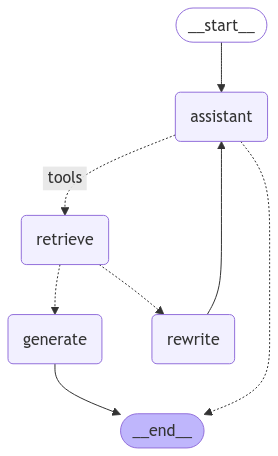

In [112]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(State)

# Define the nodes
workflow.add_node("assistant", assistant)  # assistant
workflow.add_node("retrieve", ToolNode(tools))  # retrieve
workflow.add_node("generate", generate)  # generatae
workflow.add_node("rewrite", rewrite)  # rewrite

# Build graph
workflow.add_edge(START, "assistant")

workflow.add_conditional_edges(
    "assistant",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_conditional_edges(
    "retrieve",
    decide_to_generate,
    {
        "generate": "generate",
        "rewrite": "rewrite",
    },
)

workflow.add_edge("rewrite", "assistant")
workflow.add_edge("generate", END)

# Compile
graph = workflow.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [113]:
import pprint

inputs = {"messages": [HumanMessage(content="What does Lilian Weng say about the types of agent memory?")]}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)

---CALL ASSISTANT---
"Output from node 'assistant':"
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zYShV8dQiUhA6NgcW9RYpqqG', 'function': {'arguments': '{"query":"types of agent memory"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 89, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5c7c46f2-b791-4d9e-ab75-ee367b23cf6b-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'types of agent memory'}, 'id': 'call_zYShV8dQiUhA6NgcW9RYpqqG', 'type': 'tool_call'}], usage_metadata={'input_tokens': 89, 'output_tokens': 19, 'total_token

In [115]:
# Final generation
print(value["messages"][-1].content)

Lilian Weng discusses two main types of agent memory:

1. **Short-term Memory**: This is associated with in-context learning, where the model utilizes its short-term memory to learn and adapt based on the immediate context provided in the input. This type of memory is transient and is used to process and respond to the current task or query.

2. **Long-term Memory**: This type of memory allows the agent to retain and recall information over extended periods. It often involves leveraging an external vector store and fast retrieval mechanisms to store and access a potentially infinite amount of information. This enables the agent to remember past interactions or data that are not part of its immediate context.

Additionally, Weng mentions the use of external tools or APIs as a form of memory extension. This allows the agent to access information that is not embedded within its model weights, such as current data, code execution capabilities, and proprietary information sources. This tool

In [116]:
inputs = {"messages": [HumanMessage(content="What does Lilian Weng say about the Prompt Engineering?")]}

for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)

---CALL ASSISTANT---
"Output from node 'assistant':"
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7cklSUCNTh6G9XwMwDQk8tn2', 'function': {'arguments': '{"query":"Prompt Engineering"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 87, 'total_tokens': 104, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-22d90b5c-5a0e-4e94-8bb4-965cf4d64555-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Prompt Engineering'}, 'id': 'call_7cklSUCNTh6G9XwMwDQk8tn2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 87, 'output_tokens': 17, 'total_tokens': 10

In [118]:
# Final generation
print(value["messages"][-1])

Lilian Weng suggests that some prompt engineering papers are unnecessarily long, as the techniques can often be summarized in a few sentences, with the rest focused on benchmarking. She believes that a shared benchmark infrastructure would be more beneficial to the community. Additionally, she notes that setting up iterative prompting or external tool use is not trivial, nor is aligning the research community to adopt such methods.


In [119]:
inputs = {"messages": [HumanMessage(content="What is a Autonomous Agent?")]}

for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)

---CALL ASSISTANT---
"Output from node 'assistant':"
{ 'messages': [ AIMessage(content='An autonomous agent is a system that operates independently to perform tasks or make decisions without human intervention. These agents are designed to perceive their environment, process information, and take actions to achieve specific goals. They can adapt to changes in their environment and learn from experiences to improve their performance over time.\n\nAutonomous agents are used in various fields, including robotics, artificial intelligence, and software applications. In the context of AI, they often involve complex algorithms and models, such as reinforcement learning, to enable decision-making and problem-solving capabilities. These agents can be found in applications ranging from self-driving cars and drones to virtual assistants and automated trading systems.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 129, 'prompt_tokens': 81, 'total_tok

In [121]:
# Final generation
print(value["messages"][-1].content)

An autonomous agent is a system that operates independently to perform tasks or make decisions without human intervention. These agents are designed to perceive their environment, process information, and take actions to achieve specific goals. They can adapt to changes in their environment and learn from experiences to improve their performance over time.

Autonomous agents are used in various fields, including robotics, artificial intelligence, and software applications. In the context of AI, they often involve complex algorithms and models, such as reinforcement learning, to enable decision-making and problem-solving capabilities. These agents can be found in applications ranging from self-driving cars and drones to virtual assistants and automated trading systems.
